The aim of this notebook is to generate coefficients for the polynomial approximation of the Taylor series (about $x=0$) for the composition of the Gaussian function with Arcsin.

Recall that we define the Gaussian as $$g_\sigma(x) = {\rm e}^{-\frac{x^2}{2\sigma^2}}$$ and therefore, $$g_\sigma(\arcsin(x)) = {\rm e}^{-\frac{\arcsin(x)^2}{2\sigma^2}}$$


---


The Taylor expansion of $\arcsin(x)$ about $x=0$ is given by:
$$\arcsin(x) = \sum_{n=0}^{\infty} s_n x^{2n}$$ where $$s_n = \frac{1}{2^{2n}}\binom{2n}{n} \frac{1}{2n+1}$$

It can be shown that the Taylor series of our target function is: $$f(x) = 1+ \sum_{n=1}^{\infty} c_n x^{2n}$$ where $$c_n = \frac{1}{n!} B_{n}(g_0,2!g_1,\ldots,n!g_{n-1})$$
The $n$-th complete Bell polynomials are represented as $B_n$ and the variable $g_m$ is related to a normalised Cuachy product from the $\arcsin(x)$ Taylor series.


---
**Truncated Polynomial**

We cannot evaluate an infinite series so we truncate.
Let $$P_d(x) = 1 + \sum_{n=1}^{d} c_d x^{2d}$$ be a degree-$2d$ polynomial.

We also want a series expansion in terms of the Chebyshev polynomials.

In [76]:
import numpy as np 
import math 
from sympy import bell, symbols 
import json
from numpy.polynomial import Polynomial, chebyshev

class TargetSeriesCoefficients:
    """
    A class to compute coefficients for the series expansion of the target function:
        F(x) = Exp[ - 1/(2*sigma^2) * arcsin(x)^2 ].

    **Attributes:**
    > "sigma" : A positive float representing the standard deviation of the Gaussian function.
    > "Coefficient" : refers to the coefficients in a series expansion, which can be either Taylor or Chebyshev coefficients.
    > "(Coefficient) Index" : refers to the i associated with the coefficient c_i in the series expansion.
    > "Degree" : refers to the degree of the polynomial or Chebyshev polynomial, which is 2 times the index (i.e., degree = 2 * index).

    The class supports two primary bases for the Taylor series expansions about x=0:

    1.  **Standard Polynomial Taylor Series (P_d(x)):**
        Represented as a truncated polynomial:
        P_d(x) = 1 + sum_{n=1}^{d} c_n * x^(2n)
        Where 'd' is the maximum coefficient index (corresponding to a polynomial of degree 2d). 
        The coefficients 'c_n' are computed using Bell polynomials.
        (We refer to the Standard Polynomial series as "Taylor" series in the context of this class).

    2.  **Chebyshev Series of the First Kind (T_n(x)):**
        Represented as:
        Q_d(x) = sum_{n=0}^{d} l_n * T_{2n}(x)
        Where 'd' is the maximum coefficient index (corresponding to the Chebyshev of degree 2d) and 'l_n' are the Chebyshev coefficients.
        Note that only even-indexed Chebyshev polynomials (T_0, T_2, T_4, ...) are used due to the even nature of the target function's Taylor expansion.
        The conversion from Taylor to Chebyshev coefficients involves pre-computed Chebyshev coefficient arrays loaded from 'cheby_coeffs.json'.

    **Key Assumptions & Conventions:**
    * **Input Range for x:** While not explicitly enforced by methods, the arcsin(x) function
        is real-valued for x in [-1, 1]. The series expansions are generally valid within this range.
    * **Coefficient Ordering:** All lists/arrays of coefficients (e.g., `c_n`, `l_n`) are ordered by increasing index. 
        For a list representing coefficients up to index 'I', the element at index `i` corresponds to the coefficient of the either x^(2i) for Standard Polynomial series or T_{2i}(x) for Chebyshev series.
    * **Implied Zeros for Odd Powers:** For Standard Polynomial and Chebyshev expansions where only even powers/polynomials appear (e.g., x^0, x^2, x^4, ... or T_0, T_2, T_4, ...), the coefficient lists directly store c_0, c_1, c_2, ... or l_0, l_1, l_2, ...
        The `insert_zeros_loop` static method is used internally to convert these compressed lists into the standard format expected by `numpy.polynomial.Polynomial` and `numpy.polynomial.chebyshev.Chebyshev` objects, which require explicit zeros for missing odd powers.
    * **cheby_coeffs.json:** This file is expected to exist in the same directory as the script and contain pre-computed Chebyshev coefficients. 
        Its structure is assumed to be a dictionary or list where relevant coefficients can be accessed by integer (or string representation of integer) keys/indices.
        (Further detail on its structure should be given under the relevant methods).

    **Usage:**
    To use this class, instantiate it with a positive sigma value, then call methods to compute Taylor or Chebyshev coefficients as needed. 
    """
    # ... rest of your class code
    def __init__(self, sigma=1):
        if sigma <= 0:
            raise ValueError("Sigma must be positive.")
        self.sigma = sigma

    def insert_zeros_loop(self, original_list):
        """
        Inserts a zero after each element in the original list, except for the last element.
        """
        new_list = []
        for i, item in enumerate(original_list):
            new_list.append(item)
            if i < len(original_list) - 1: # Don't add a zero after the last element
                new_list.append(0)
        return new_list

    def TargetFunction(self, x):
      """
      Returns the target function value for a given input x.
      """
      return np.exp( - (1/(2 * self.sigma**2)) * (np.arcsin(x))**2)

    def ArcsineTaylorCoeffs(self, n: int):
        """
        Takes a non-negative integer n and returns the n-th order coefficient of the Taylor series expansion of arcsine.
            arcsine(x) = \sum_{n=0}^{\infty} s_n x^{2n+1} 
        Args:
            n (int): The index of the coefficient to return.
        Returns:
            float: The n-th coefficient of the Taylor series expansion of arcsine.

        Note: 
            arcsine has an odd order expansion, so coefficient n corresponds to the term of degree 2n+1.
        """
        if n < 0:
            raise ValueError("n must be non-negative.")
        
        return (1/(2**(2*n)))*math.comb(2*n,n)*(1/(2*n+1))
    
    def ArcsineCauchyCoeffs(self, m: int):
        """
        Computes the m-th order coefficient of the Cauchy product of arcsine with itself.
        The Cauchy product of arcsin(x)^2 is given by:
            arcsin(x) * arcsin(x) = \sum_{m=0}^{\infty} u_m x^{2m+2}
            u_m = \sum_{j=0}^{m} s_j * s_{m-j}.
        Args:
            m (int): The index of the coefficient to return.
        Returns:
            float: The m-th order coefficient of the Cauchy product of arcsine with itself.
        """
        if m < 0:
            raise ValueError("m must be non-negative.")
        total_sum = 0
        for j in range(m+1):  # Loop from j = 0 to m
            first_term = self.ArcsineTaylorCoeffs(j)
            second_term = self.ArcsineTaylorCoeffs(m - j)
            total_sum += first_term * second_term
        
        return total_sum
    
    def ScaledArcsineCauchyCoeffs(self, m: int):
        """
        Scaled version of the Cauchy coefficients for arcsine, scaled by -1/(2*sigma^2).
        """
        return (-2*(self.sigma**2))**(-1) * self.ArcsineCauchyCoeffs(m)
    
    def TargetTaylorCoeff(self, n: int):
        """
        Computes the coefficient of index n (corresponding to x^{2n}) of the Taylor series expansion of the target function about x=0.
        The coefficients are defined using the n-th complete Bell polynomial:
            c_n = \frac{1}{n!} B_{n}(1! * g(0), 2! * g(1), \dots, (n)! * g(n-1))
            g(m) = -\frac{1}{2\sigma^2} u_m and u_m is the m-th Cauchy coefficient of arcsine.
        The n-th complete Bell polynomial is a sum over n many partial Bell polynomials:
            B_{n}(x_1, x_2, \dots, x_n) = \sum_{k=1}^{n} B_{n,k}(x_1, x_2, \dots, x_n)
        Args:
            n (int): The index of the coefficient to return.
        Returns:
            tuple: A tuple containing the coefficient of index n (corresponding to x^{2n}) and a string representation of the coefficient.
        """
        if n == 0:
            return 1.0, "0-th coefficient (~ x^0}): c_0 = 1"

        g_vec = [math.factorial(k+1) * self.ScaledArcsineCauchyCoeffs(k) for k in range(n)]
        B = [0.0] * (n + 1)
        B[0] = 1.0
        for i in range(1, n + 1):
            B[i] = sum(math.comb(i - 1, k - 1) * g_vec[k - 1] * B[i - k] for k in range(1, i + 1))
        result = (1 / math.factorial(n)) * B[n]
        output = f"{n}-th coefficient (~ x^{2*n}): c_{n} = {result}"
        return result, output
    
    def ListTargetTaylorCoeff(self, trunc_index: int, full: bool=False):
        """
        Produces a list of coefficients for the Taylor series expansion of the target function about x=0, up to the specified trunc_degree.
        Args:
            trunc_index (int): The maximum coefficient index (corresponding to a polynomial of degree 2d) of the Taylor series expansion.
            full (bool): If True, the list will include zeros for odd powers.
        Returns:
            list: A list of coefficients for the Taylor series expansion.
        Note:
            The i-th element of the list corresponds to the coefficient c_i for the term x^(2i).
            All coefficient lists start from c_0 and go up to c_trunc_index.
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ListTargetTaylorCoeff(3)
        [1,2,3,4]

        -> c_0 = 1, c_1 = 2, c_2 = 3, c_3 = 4
        -> The polynomial is: 1 + 2x^2 + 3x^4 + 4x^6
        """
        output_list = [self.TargetTaylorCoeff(n)[0] for n in range(0, trunc_index + 1)]
        if full==True:
            return self.insert_zeros_loop(output_list)
        else:
            return output_list
    
    def ChebyCoeff(self, degree: int):
        """
        Reads in the Chebyshev polynomial coefficients from a JSON file and returns the coefficients for the degree-th order Chebyshev polynomial of the first kind.
        Args:
            degree (int): The order of the Chebyshev polynomial to return coefficients for.
        Returns:
            list: A list of coefficients for the Chebyshev polynomial of the first kind of order degree.
        Note:
            The input degree must be a multiple of 2.
            The coefficients are stored in a JSON file named 'cheby_coeffs.json'.
            All coefficient lists start from t_0 and go up to t_degree.
            The largest even degree Chebyshev polynomial is 60, so the maximum degree cannot exceed 60.
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ChebyCoeff(4)
        [1,-8,8]

        -> t_0 = 1, t_2 = 2, t_4 = 3
        -> The polynomial is: 1 + -8x^2 + 8x^4 = T_4(x)
        """
        if degree < 0 or degree % 2 != 0 or degree > 60:
            raise ValueError("degree must be a non-negative even integer less than or equal to 60.")
        
        with open('cheby_coeffs.json', 'r') as f:
            coeffs = json.load(f)

        return coeffs[int(degree/2)]

    def ListChebyCoeff(self, max_degree: int):
        """
        Returns a list of coefficient arrays for Chebyshev polynomials of the first kind from degree-0 to degree-max_degree in steps of 2.
        Args:
            max_degree (int): The maximum order of the Chebyshev polynomial.
        Returns:
            list: A list of coefficient arrays for Chebyshev polynomials of the first kind.
        Note:
            The l-th array in the list corresponds to the coefficients for the Chebyshev polynomial of order (2l).
            The i-th element of the l-th array corresponds to the coefficient for x^2i in the Chebyshev polynomial of order (2l).
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ListChebyCoeff(4)
        [[1], [-1, 2], [1, -8, 8]]

        -> The first array corresponds to T_0(x) = 1
        -> The second array corresponds to T_2(x) = -1 + 2x^2
        -> The third array corresponds to T_4(x) = 1 - 8x^2 + 8x^4
        """
        with open('cheby_coeffs.json', 'r') as f:
            coeffs = json.load(f)

        return coeffs[:max_degree//2 + 1]
    
    def ListTargetChebyCoeff(self, trunc_index: int, full: bool=False):
        """
        Produces a list of coefficients for the Chebyshev polynomial decomposition of the target function P_d(x).
        \sum_{n=0}^{d} c_n x^{2n} = \sum_{n=0}^{d} l_n T_{2n}(x)
        l_n = \frac{1}{t^{(2n)}_n} (c_n - \sum_{m=n+1}^{d} l_m t^{(2n)}_m)
        where t^{(2n)}_m is the m-th coefficient of the Chebyshev polynomial of order (2n). 
        Args:
            trunc_index (int): The maximum coefficient index (corresponding to the Chebyshev of degree 2d) of the Chebyshev polynomial decomposition.
            full (bool): If True, the list will include zeros for odd powers.
        Returns:
            list: A list of coefficients for the Chebyshev polynomial decomposition of the target function.
        Note:
            The i-th element of the list corresponds to the coefficient for the Chebyshev polynomial of degree (2i)
            All coefficient lists start from l_0 and go up to l_max_index.
        ---
        Example:
        (Example list not necessarily representative of actual output, just for illustration)
        >>> D = TargetSeriesCoefficients(sigma=1)
        >>> D.ListTargetChebyCoeff(4)
        [1,-2,3,-4,5]

        -> l_0 = 1, l_1 = -2, l_2 = 3, l_3 = -4, l_4 = 5
        -> The polynomial is: 1 - 2T_2(x) + 3T_4(x) - 4T_6(x) + 5T_8(x)
        -> This is equivalent to the Taylor series expansion of the target function up to degree 8.
        """
        taylor_coeff_list = self.ListTargetTaylorCoeff(trunc_index)

        if len(taylor_coeff_list) != trunc_index+1:
            raise ValueError(f"taylor_coeff_list must be of length {trunc_index+1}")

        cheby_coeff_list = [0] * (trunc_index+1)
        # print(f"cheby_coeff_list: {cheby_coeff_list}")

        print(taylor_coeff_list[trunc_index])# Delete Me
        print(self.ChebyCoeff(2*trunc_index)[trunc_index])# Delete Me
        cheby_coeff_max = taylor_coeff_list[trunc_index] / self.ChebyCoeff(2*trunc_index)[trunc_index]
        cheby_coeff_list[trunc_index] = cheby_coeff_max
        # print(f"cheby_coeff_list: {cheby_coeff_list}")

        for k in range(trunc_index-1,-1,-1): # Count in reverse
            # print(f"k = {k}")
            tail_sum = 0
            for m in range(k+1,trunc_index+1):
                # print(f"For k={k}: m={m} and cheby_coeff_list[{m}]={cheby_coeff_list[m]} and ChebyCoeff({2*m})[{k}]={ChebyCoeff(2*m)[k]}")
                scaled_coeff = cheby_coeff_list[m] * self.ChebyCoeff(2*m)[k]
                # print(f"scaled_coeff = {scaled_coeff}")
                tail_sum += scaled_coeff
                # print(f"tail_sum = {tail_sum}")
                
            cheby_coeff_k = (taylor_coeff_list[k] - tail_sum) / self.ChebyCoeff(2*k)[k]
            cheby_coeff_list[k] = cheby_coeff_k

        if full==True:
            return self.insert_zeros_loop(cheby_coeff_list)
        else:
            return cheby_coeff_list
    
    def TargetChebyCoeff(self, trunc_index: int, n: int):
        """
        Computes the coefficient of index n (corresponding to x^{2n}) of the Taylor series expansion of the target function about x=0 in terms of Chebyshev polynomials.
        Args:
            trunc_index (int): The maximum coefficient index of the Chebyshev polynomial decomposition.
            n (int): The index of the coefficient to return.
        Returns:
            float: The coefficient of index n (corresponding to x^{2n}) of the Chebyshev polynomial decomposition of the target function P_d(x).
        Note:
            trunc_index must be a non-negative even integer.
            We must specify trunc_index as this function calls ListTargetChebyCoeff.
        """
        if n < 0:
            raise ValueError(f"{n} must be non-negative.")
        if trunc_index < 0 or trunc_index % 2 != 0:
            raise ValueError(f"{trunc_index} must be a non-negative even integer.")
        
        cheby_coeff_list = self.ListTargetChebyCoeff(trunc_index)
        if len(cheby_coeff_list) <= n:
            raise ValueError(f"n={n} is out of bounds for the computed coefficients.")
        
        return cheby_coeff_list[n]

    def CoeffListToPolynomial(self, coeff_list: list, expansion_type: str):
        """
        Converts a list of coefficients into a Polynomial or Chebyshev polynomial object.
        Args:
            coeff_list (list): List of coefficients.
            expansion_type (str): Type of polynomial, either "TAYLOR" or "CHEBYSHEV".
        Returns:
            Polynomial or Chebyshev object based on the expansion_type.
        Note:
            The coefficients in the list should be in ascending order of powers, i.e., the first element corresponds to the constant term (x^0), the second to the coefficient of x^2, and so on.
            Recall that we are dealing with even powers only, so the coefficients for odd powers will be zero and not included in the initial list.
        """
        # Raise error if there is a zero in the input list
        if any(x == 0 for x in coeff_list):
            raise ValueError("The input list must not contain any zeros.")
        
        if expansion_type == "TAYLOR":
            coeff_list = self.insert_zeros_loop(coeff_list)
            return Polynomial(coeff_list)

        elif expansion_type == "CHEBYSHEV":
            coeff_list = self.insert_zeros_loop(coeff_list)
            return chebyshev.Chebyshev(coeff_list)

        else:
            raise ValueError("expansion_type must be either 'TAYLOR' or 'CHEBYSHEV'")

Let us now install pyqsp

In [2]:
!pip install pyqsp

In [3]:
import pyqsp
from pyqsp import angle_sequence, response
from pyqsp.poly import (polynomial_generators, PolyTaylorSeries)

# Specify the target function
func = lambda x, sigma: np.exp(-1/(2*sigma**2) * np.arcsin(x)**2)

In [74]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def Alt_DegreeFromError(sigma: float, error: float, n: int):
    """
    Computes a lower bound on 2*degree based on the error tolerance, sigma and the number of qubits.
    Args:
      sigma (float): The standard deviation of the Gaussian.
      error (float): The desired error tolerance.
      n (int): The number of qubits
    Returns:
      int: The estimated 2*degree.

    Note:
      Output is rounded up to the nearest even integer.
    """
    return math.ceil((1 / (1-np.sin(1))) * ((np.pi**2 / (8 * sigma**2)) + np.log(1/error))  / 2) * 2 

def NumericalDegreeFromError(sigma: float, error: float, n: int, initial_degree = None, print_desc: bool = False, plot: bool = False):
    """
    Computes an estimate on 2*degree based on the error tolerance and sigma.
    Args:
      sigma (float): The standard deviation of the Gaussian.
      error (float): The desired error tolerance.
      n (int): The number of qubits
      initial_degree : A guess for the degree of a polynomial (Even number, **not** the index)
      print_desc (bool): If True, prints descriptive messages about the degree bounds and adjustments.
      plot (bool): If True, plots the approximated function against the target function and the absolute difference.
    Returns:
      int: The estimated 2*degree.
    Note:
      For very small error it is good to try guess a smaller initial_degree.
    """
    if initial_degree is None:
      initial_degree = Alt_DegreeFromError(sigma, error, n)

    print(f"Initial degree guess: {initial_degree}\n") if print_desc else None
    max_val = np.sin(1 - (1/(2**n)))
    x_eval = np.linspace(0.5,max_val, 2**n)
    targ_func = lambda x: np.exp( - (1/(2 * sigma**2)) * (np.arcsin(x))**2)

    d = initial_degree
    delta = 0
    final_poly = None
    
    while True:
      init = TargetSeriesCoefficients(sigma=sigma)
      coeff_list = init.ListTargetTaylorCoeff(d//2)
      poly = init.CoeffListToPolynomial(coeff_list, "TAYLOR")
      delta = np.max(np.abs(poly(x_eval) - targ_func(x_eval)))

      print("-----"* 10) if print_desc else None
      print(f"degree={d} gives delta={delta}") if print_desc else None
      print("-----"* 10) if print_desc else None

      print(f"Value of x @ degree {d} giving largest delta: {x_eval[np.argmax(np.abs(poly(x_eval) - targ_func(x_eval)))]}\n") if print_desc else None

      if delta <= error:
        # Try a smaller degree
          final_poly = poly
          d -= 2
          if d < 0:
            break 
      else:
        final_deg = d + 2
        init = TargetSeriesCoefficients(sigma=sigma)
        coeff_list = init.ListTargetTaylorCoeff(final_deg // 2)
        final_poly = init.CoeffListToPolynomial(coeff_list, "TAYLOR")

        if plot == True:
          fig, axs = plt.subplots(1, 2, figsize=(20, 10))
          x = np.linspace(0, max_val, 100)
          # Plot 1: Target Function and Approximated Function
          axs[0].plot(x, targ_func(x), label=f'Target Function @ sigma={sigma}', color='blue')
          axs[0].plot(x, final_poly(x), label=f'Approximated Function @ degree={final_deg}', color='orange')
          axs[0].set_title(f'Approximation of Target Function with Degree {final_deg}')
          axs[0].set_xlabel('x')
          axs[0].set_ylabel('Function Value')
          axs[0].legend()
          axs[0].grid() 

          # Plot 2: Absolute Difference
          axs[1].semilogy(x, np.abs(poly(x) - targ_func(x)), label='Absolute Difference', color='red')
          axs[1].axhline(y=error, color='green', linestyle='--', label='Error Tolerance')
          axs[1].axvline(x=np.sin(1 - (1/(2**n))), color='purple', linestyle='--', label='Max of domain')
          axs[1].set_title('Absolute Difference between Target and Approximated Function')
          axs[1].set_xlabel('x')
          axs[1].set_ylabel('Absolute Difference')
          axs[1].legend()
          axs[1].grid()

          plt.show()
        # If previous is too small, increment degree
        print("-----"* 10) if print_desc else None
        print(f"Final degree: {final_deg} | {d+2}") if print_desc else None
        print("-----"* 10) if print_desc else None
        return final_deg
      

        
def QSPTest(angle_list: list, x_data: list):
    """
    **A lot copied over from pyqsp.**
    Computes the output of a Quantum Signal Processing (QSP) operation for given angles and input data.
    Args:
        angle_list (list): List of angles for the QSP operation.
        x_data (list): List of input data points to apply the QSP operation on.
    Returns:
        list: A list of outputs corresponding to each input data point after applying the QSP operation.
    """
    # Define Signal Operator
    sig_op = lambda x: np.array(
            [[x, 1j * np.sqrt(1 - x**2)],
             [1j * np.sqrt(1 - x**2), x]])
    
    # Define Angle Operator
    qsp_op = lambda phi: np.array(
           [[np.exp(1j * phi), 0.],
            [0., np.exp(-1j * phi)]])
    
    angle_matrices = []
    for phi in angle_list:
        angle_matrices.append(qsp_op(phi))
        
    y_data = []
    for x in x_data:
        W = sig_op(x)
        U = angle_matrices[0]
        for angle_matrix in angle_matrices[1:]:
            U = U @ W @ angle_matrix
        y_data.append(U[0, 0]) # Take the top left element as the output

    return y_data, [np.imag(y) for y in y_data], [np.real(y) for y in y_data]

def GetQSPAngleList(sigma: float, max_degree: int):
  """
  Computes the list of angles for QSP.
  """
  if max_degree < 0 or max_degree % 2 != 0:
    raise ValueError("max_degree must be a non-negative even integer.")
  
  X = TargetSeriesCoefficients(sigma) # Initialise the instance
  coeff_list = X.ListTargetChebyCoeff(int(max_degree//2)) # Recall that ListTargetChebyCoeff takes a even number corresponding to index of coefficient.
  poly_data = X.CoeffListToPolynomial(coeff_list, "CHEBYSHEV")
  
  return angle_sequence.QuantumSignalProcessingPhases(poly_data, method='sym_qsp', chebyshev_basis=True)[0]

def GetQSPAngleListAdv(sigma: float, init_trunc_degree: int, error: float, plot: bool=False, print_desc: bool=True):
  """
  Computes the QSP angle list for a given sigma and error tolerance.
  Capable of outputting a plot of the approximated function against the target function and the absolute difference.

    Args:
        sigma (float): The standard deviation of the Gaussian.
        init_trunc_degree (int): The initial maximum degree for the polynomial.
        error (float): The desired error tolerance.
        plot (bool): If True, plots the approximated function against the target function and the absolute difference.
        print_desc (bool): If True, prints descriptive messages about the degree bounds and adjustments.
    Returns:
        list: A list of angles for the QSP approximation.
    Note:
        The function first checks if the init_trunc_degree is a good guess by comparing it to the naive bound and the numerical bound.
        If the init_trunc_degree is smaller than the naive bound, it will print a warning and suggest a new starting bound based on the numerical bound.
        The function then computes the QSP angle list using the working degree, which is either the init_trunc_degree or the numerical bound.
        If plot is True, it will plot the approximated function against the target function and the absolute difference.
        **We require a degree as input and not an index, so the input should be an even integer.**
  """

  if init_trunc_degree < 0 or init_trunc_degree % 2 != 0:
    raise ValueError("init_trunc_degree must be a non-negative even integer.")
  # Initialise degree bounds
  # number of qubits is set to 10, but can be changed.
  naive_degree = Alt_DegreeFromError(sigma, error, 10)
  numerical_degree = NumericalDegreeFromError(sigma, error, 10, initial_degree = init_trunc_degree)
  working_degree = init_trunc_degree

  # Compare init_trunc_degree to Alt_DegreeFromError function.
  if (init_trunc_degree < naive_degree) is True:
    print(f"Your initial degree guess of {init_trunc_degree} is smaller than the naive bound of {naive_degree}.\n") if print_desc else None
    if (init_trunc_degree < numerical_degree) is True:
      print(f"Your initial degree guess of {init_trunc_degree} is also smaller than the numerical bound {numerical_degree}.\n \
                (!) We will use the numerical bound *or* you can re-run the function with a better starting degree.(!) \n \
                (1) We suggest a new starting bound of {numerical_degree + 4}. (!)") if print_desc else None
      working_degree = numerical_degree
      print("-----"*10) if print_desc else None
      print(f"Your initial degree guess of {init_trunc_degree} is reduced to {working_degree}(!)") if print_desc else None
      print("-----"*10) if print_desc else None
      print("\n") if print_desc else None
    else:
      print(f"Your initial degree guess of {init_trunc_degree} is larger than the numerical bound of {numerical_degree}.\n (!)We will use the numerical bound.(!)\n") if print_desc else None
      working_degree = numerical_degree
      print("-----"*10) if print_desc else None
      print(f"Your initial degree guess of {init_trunc_degree} is reduced to {working_degree}(!)") if print_desc else None
      print("-----"*10) if print_desc else None
      print("\n") if print_desc else None
  else:
    print(f"Your initial degree guess {init_trunc_degree} is larger than the naive bound of {naive_degree}, so we start from the latter and try get a better bound.\n") if print_desc else None
    working_degree = NumericalDegreeFromError(sigma, error, 10, initial_degree = naive_degree)
    print("-----"*10) if print_desc else None
    print(f"Your initial degree guess {init_trunc_degree} is reduced to {working_degree}(!)") if print_desc else None
    print("-----"*10) if print_desc else None
    print("\n") if print_desc else None
  
  print("-----"*10) if print_desc else None
  print(f"> The working degree is now {working_degree} <") if print_desc else None
  print("-----"*10) if print_desc else None
  print("\n") if print_desc else None

  # Add code to allow user to overrule
  user_input = input(f"Do you want to use a different working degree? (y/n): ")
  if user_input.lower() == 'y':
        while True:
            try:
                new_degree = int(input("Enter the desired even, non-negative degree: "))
                if new_degree >= 0 and new_degree % 2 == 0:
                    working_degree = new_degree
                    print("-----"*10) if print_desc else None
                    print(f"> Using user-specified degree: {working_degree} <") if print_desc else None
                    print("-----"*10) if print_desc else None
                    break
                else:
                    print("Invalid input. Please enter an even, non-negative integer.")
            except ValueError:
                print("Invalid input. Please enter an integer.")
  else:
      print("Using the calculated working degree.") if print_desc else None

  # Given the working_degree we can call GetQSPAngleList.
  # Recall that the working_degree is twice the index we need to call.
  print(f"This is the type of the working degree divided by 2: {type(working_degree//2)}") 
  angle_list = GetQSPAngleList(sigma, working_degree)

  if plot == True:
    y_plot_data = QSPTest(angle_list, np.linspace(0, 1, 100))[1]
    y_targ_func_data = [np.exp(-(1/(2 * sigma**2)) * (np.arcsin(x))**2) for x in np.linspace(0, 1, 100)]

    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot 1: Approximate and Target functions
    axs[0].plot(np.linspace(0, 1, 100), y_plot_data, color='red', label='Approximated function')
    axs[0].plot(np.linspace(0, 1, 100), y_targ_func_data, color='black', label='Target function')
    axs[0].set_xlabel('X-axis')
    axs[0].set_ylabel('Y-axis')
    axs[0].set_title('Action of the approximation polynomial on the Wx operator')
    axs[0].grid(True)
    axs[0].legend()

    # Plot 2: Absolute difference
    axs[1].semilogy(np.linspace(0, 1, 100), np.abs(np.array(y_plot_data) - np.array(y_targ_func_data)), color='blue', label='Absolute difference')
    axs[1].axhline(y=error, color='r', linestyle='--', label=f'Error = {error}')
    axs[1].axvline(x=np.sin(1), color='g', linestyle='--', label='x = sin(1)')
    axs[1].set_xlabel('X-axis')
    axs[1].set_ylabel('Y-axis')
    axs[1].set_title('Absolute difference between the approximated and target functions')
    axs[1].grid(True)
    axs[1].legend()
        
    plt.show() if plot else None

  return angle_list, working_degree, numerical_degree, naive_degree

We can construct a simple example to see how the code will handle a given sigma and a given error tolerance.

For demonstration:
$$ \sigma = 1$$
$$ \epsilon = 10^{-2}$$

We take a initial guess of the degree to be $10$.

In [77]:
# Simple degree test for small error and sigma =1
s, err = 1, 1e-5
X = TargetSeriesCoefficients(sigma=s)
naive_degree = Alt_DegreeFromError(s, err, 10)
print(f"Naive degree: {naive_degree}")

Naive degree: 82


Initial degree guess: 82

--------------------------------------------------
degree=82 gives delta=7.223674991507778e-10
--------------------------------------------------
Value of x @ degree 82 giving largest delta: 0.8409429446765868

--------------------------------------------------
degree=80 gives delta=1.0574288111797614e-09
--------------------------------------------------
Value of x @ degree 80 giving largest delta: 0.8409429446765868

--------------------------------------------------
degree=78 gives delta=1.5491791183208647e-09
--------------------------------------------------
Value of x @ degree 78 giving largest delta: 0.8409429446765868

--------------------------------------------------
degree=76 gives delta=2.2715753722479803e-09
--------------------------------------------------
Value of x @ degree 76 giving largest delta: 0.8409429446765868

--------------------------------------------------
degree=74 gives delta=3.333854525777724e-09
--------------------------------

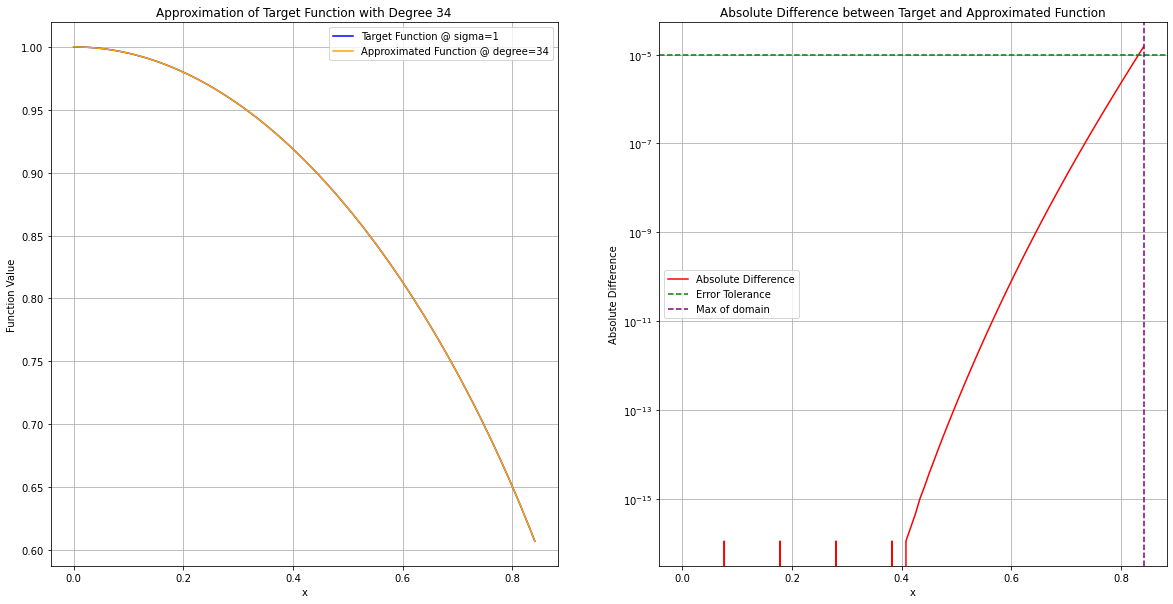

--------------------------------------------------
Final degree: 34 | 34
--------------------------------------------------


In [68]:
init_deg_full = NumericalDegreeFromError(s, err, 10, initial_degree = naive_degree, print_desc=True, plot=True)

Your initial degree guess of 34 is smaller than the naive bound of 82.

Your initial degree guess of 34 is larger than the numerical bound of 34.
 (!)We will use the numerical bound.(!)

--------------------------------------------------
Your initial degree guess of 34 is reduced to 34(!)
--------------------------------------------------


--------------------------------------------------
> The working degree is now 34 <
--------------------------------------------------


Using the calculated working degree.
This is the type of the working degree divided by 2: <class 'int'>
-0.0018687122037553598
8589934592
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.711e-01
iter: 002 --- err: 4.050e-02
iter: 003 --- err: 9.915e-03
iter: 004 --- err: 2.463e-03
iter: 005 --- err: 6.148e-04
iter: 006 --- err: 1.536e-04
iter: 007 --- err: 3.840e-05
iter: 008 --- err: 9.599e-06
iter: 009 --- err: 2.400e-06
iter: 010 --- err: 5.999e-07
iter: 011 --- err: 1.500e

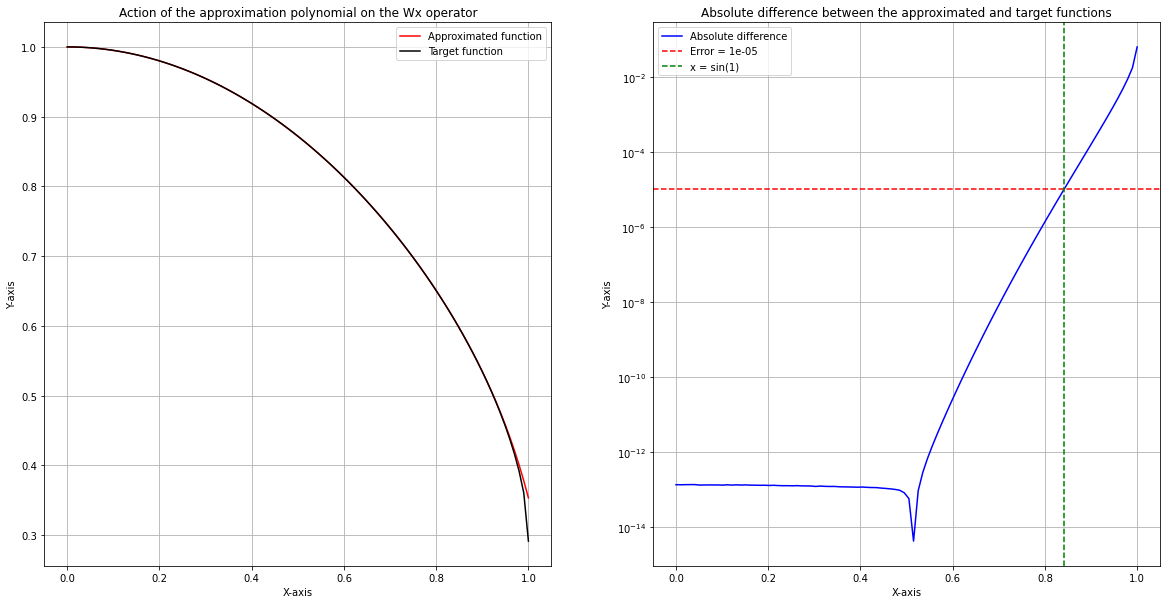

(array([-2.26009012e-13, -8.45483007e-12, -1.54678091e-10, -1.84499249e-09,
        -1.61484356e-08, -1.10703805e-07, -6.19858448e-07, -2.92066103e-06,
        -1.18518137e-05, -4.22393104e-05, -1.34664419e-04, -3.91603111e-04,
        -1.06379329e-03, -2.79372955e-03, -7.51638082e-03, -2.24172388e-02,
        -2.93723842e-01,  1.01718915e+00, -2.93723842e-01, -2.24172388e-02,
        -7.51638082e-03, -2.79372955e-03, -1.06379329e-03, -3.91603111e-04,
        -1.34664419e-04, -4.22393104e-05, -1.18518137e-05, -2.92066103e-06,
        -6.19858448e-07, -1.10703805e-07, -1.61484356e-08, -1.84499249e-09,
        -1.54678091e-10, -8.45483007e-12, -2.26009012e-13]),
 34,
 34,
 82)

In [78]:
init_deg = NumericalDegreeFromError(s, err, 10, initial_degree = naive_degree)

GetQSPAngleListAdv(s, init_deg, err, plot=True)

In [ ]:
def SaveQSPAngleListToFile(sigma: float, init_degree: int, error: float, angle_list: list, filename: str):
    if filename is None or not isinstance(filename, str):
        raise ValueError("Please provide a file name ending with '.txt'.")
    if not filename.endswith('.txt'):
        raise ValueError("Filename must end with .txt")
    
    result = GetQSPAngleListAdv(sigma, init_degree, error, plot=False)
    angle_list = result[0]
    working_degree = result[1]
    with open(filename, 'w') as f:
        f.write(f"% File: {filename}\n")
        f.write(f"% Input Data = [{sigma},{init_degree},{working_degree},{error}]\n")
        f.write("QSP angles form PYQSP\n")
        f.write("————————————————————\n")
        f.write(f"sigma = {sigma}\n")
        f.write(f"Initial Degree = {init_degree}\n")
        f.write(f"Working Degree = {working_degree}\n")
        f.write(f"Error = {error}\n")
        f.write("————————————————————\n\n")
        f.write(angle_list)
        f.write("\n")

In [9]:
D = TargetSeriesCoefficients(1)
D.ListTargetChebyCoeff(15)

-0.002259040377243701
536870912


[0.7098615975498401,
 -0.31100858122082237,
 -0.027643239703007496,
 -0.00916957203229675,
 -0.003250204099198199,
 -0.001141973293208182,
 -0.000377198256733646,
 -0.00011328439806583478,
 -3.015287486535261e-05,
 -6.946344791069349e-06,
 -1.3500212660315757e-06,
 -2.1452016730085704e-07,
 -2.670072217575414e-08,
 -2.437315410871836e-09,
 -1.4492198689136104e-10,
 -4.207790600589851e-12]

Your initial degree guess of 10 is smaller than the naive bound of 52.

Your initial degree guess of 10 is also smaller than the numerical bound 12.
                 (!) We will use the numerical bound *or* you can re-run the function with a better starting degree.(!) 
                 (1) We suggest a new starting bound of 16. (!)
--------------------------------------------------
Your initial degree guess of 10 is reduced to 12(!)
--------------------------------------------------


--------------------------------------------------
> The working degree is now 12 <
--------------------------------------------------


-0.009138376573272409
2048
[sym_qsp] Iterative optimization to err 1.000e-12 or max_iter 100.
iter: 001 --- err: 1.673e-01
iter: 002 --- err: 4.012e-02
iter: 003 --- err: 9.874e-03
iter: 004 --- err: 2.455e-03
iter: 005 --- err: 6.128e-04
iter: 006 --- err: 1.531e-04
iter: 007 --- err: 3.828e-05
iter: 008 --- err: 9.569e-06
iter: 009 --- err: 2.392e-06
iter: 010 --- err:

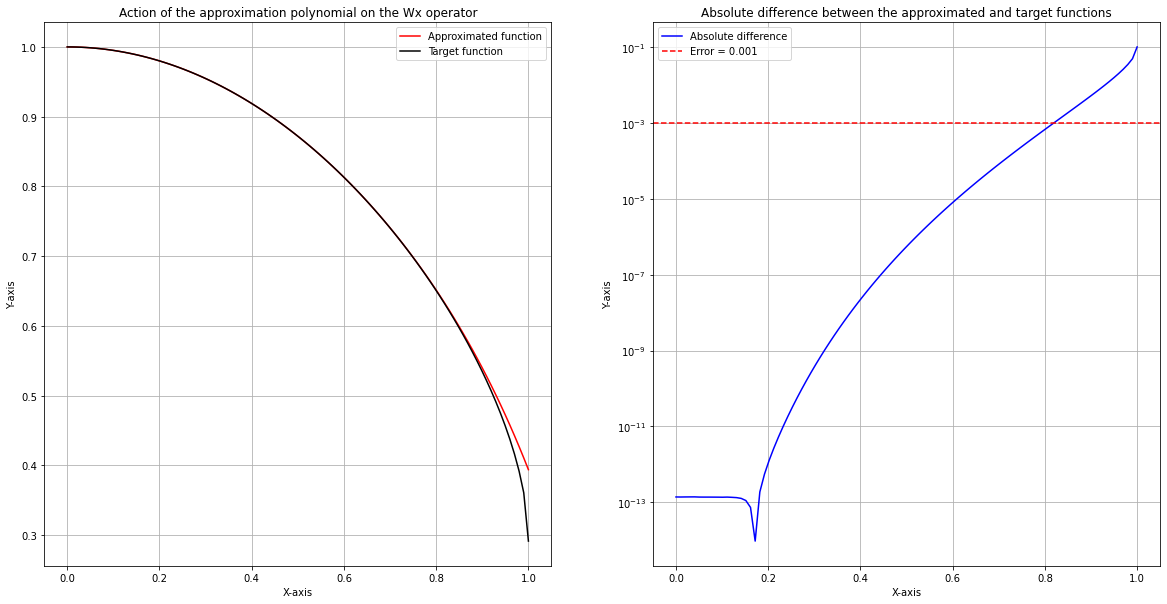

(array([-4.65131023e-06, -7.59774300e-05, -6.19315132e-04, -3.51041340e-03,
        -1.63882528e-02, -2.87956070e-01,  1.02173532e+00, -2.87956070e-01,
        -1.63882528e-02, -3.51041340e-03, -6.19315132e-04, -7.59774300e-05,
        -4.65131023e-06]),
 12,
 12,
 52)

In [23]:
GetQSPAngleListAdv(1,10,1e-3, plot=True)